In [100]:
from pymongo import MongoClient
import sys
sys.path.append('../statistical_calculations')  # Adds the statistical_calculations directory to the path
import disproportionaly_analysis
import pandas as pd
import os
import json
from datetime import datetime, timedelta 
from calendar import monthrange

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
col = db['reports']

In [160]:
end_date = datetime(2020, 11, 30)

# Define a function to reduce the date range by a month
def reduce_date_range_by_month(start_date):
    # Get the year and month of the start date
    year = start_date.year
    month = start_date.month
    
    # Calculate the new year and month
    if month == 1:  # If the current month is January
        new_year = year - 1
        new_month = 12  # December of the previous year
    else:
        new_year = year
        new_month = month - 1
    
    # Construct the new start date
    _, last_day_of_previous_month = monthrange(new_year, new_month)
    new_start_date = datetime(new_year, new_month, last_day_of_previous_month)
    
    return new_start_date

def reduce_date_range_by_year(start_date):
    # Get the year of the start date
    year = start_date.year
    
    # Calculate the new year
    new_year = year - 1
    
    # Handle the edge case for leap year (e.g., Feb 29)
    if start_date.month == 2 and start_date.day == 29:
        # Return February 28th of the new year
        return datetime(new_year, 2, 28)
    
    # Otherwise, return the same month and day of the new year
    return start_date.replace(year=new_year)

### Check monthly

In [174]:
# Loop until a signal is not found anymore

manufacturer = "MODERNA"#"PFIZER\\BIONTECH"
symptom = "Extensive swelling of vaccinated limb"
vaccine = "COVID19"
IC_intervals = []

 
start_date = datetime(2023, 12, 31)
end_date = datetime(1990, 12, 31)
first_found = datetime(1990, 1, 1)
while True:
    print(f'checking {start_date}')
    N_query = {"RECVDATE": {"$lte": start_date}}
    N = col.count_documents(N_query)
    
    D_query = {
        "RECVDATE": {"$lte": start_date},
        "vax_data": {
            "$elemMatch": {
                "VAX_MANU": manufacturer,
                "VAX_TYPE": vaccine
            }
        }
    }
    D = col.count_documents(D_query)
    
    E_query = {
        "RECVDATE": {"$lte": start_date},
        "symptoms": {
            "$elemMatch": {
                "$in": [symptom]
            }
        }
    }
    E = col.count_documents(E_query)
    
    DE_query = {'$and': [D_query, E_query]}
    DE = col.count_documents(DE_query)
    if DE >= 3: 
    
        De = D - DE
        dE = E - DE
        de = N - (DE + De + dE)
        
            
        # Ensure all necessary data is available
        if None in [DE, dE, De, de]:
            continue
        
        contingency_table = [
            [DE, dE],
            [De, de]
        ]

        rrr, sd_rrr = disproportionaly_analysis.relative_reporting_ratio(contingency_table), disproportionaly_analysis.sd_rrr(contingency_table)
        rrr_ci_lower, rrr_ci_upper = disproportionaly_analysis.confidence_interval(rrr, sd_rrr)
        
        prr, sd_prr = disproportionaly_analysis.proportional_reporting_ratio(contingency_table), disproportionaly_analysis.sd_prr(contingency_table)
        prr_ci_lower, prr_ci_upper = disproportionaly_analysis.confidence_interval(prr, sd_prr)
        
        ror, sd_ror = disproportionaly_analysis.reporting_odds_ratio(contingency_table), disproportionaly_analysis.sd_ror(contingency_table)
        ror_ci_lower, ror_ci_upper = disproportionaly_analysis.confidence_interval(ror, sd_ror)
        
        chi_square = disproportionaly_analysis.chi_square_yates(contingency_table)
        IC = disproportionaly_analysis.information_component(contingency_table)
        IC_ci_lower, IC_ci_upper = disproportionaly_analysis.confidence_interval_information_component(contingency_table, IC)
        
        IC_intervals.append({
            'Date': start_date,
            'manufacturer': manufacturer,
            'symptom': symptom,
            'IC': IC,
            'IC Lower': IC_ci_lower,
            'IC Upper': IC_ci_upper,
            'rrr': rrr, 
            'rrr Lower': rrr_ci_lower,
            'rrr Upper': rrr_ci_upper,
            'prr': prr, 
            'prr Lower': prr_ci_lower,
            'prr Upper': prr_ci_upper,
            'ror': ror, 
            'ror Lower': ror_ci_lower,
            'ror Upper': ror_ci_upper,
        })
        
        start_date = reduce_date_range_by_month(start_date)
        #print(f"Reducing by a month..., checking {start_date}")# Exit the loop if no signal is found anymore
        if start_date < end_date:
            break
    else:
        print(f"DE is {DE}")
        break

checking 2023-12-31 00:00:00
checking 2023-11-30 00:00:00
checking 2023-10-31 00:00:00
checking 2023-09-30 00:00:00
checking 2023-08-31 00:00:00
checking 2023-07-31 00:00:00
checking 2023-06-30 00:00:00
checking 2023-05-31 00:00:00
checking 2023-04-30 00:00:00
checking 2023-03-31 00:00:00
checking 2023-02-28 00:00:00
checking 2023-01-31 00:00:00
checking 2022-12-31 00:00:00
checking 2022-11-30 00:00:00
checking 2022-10-31 00:00:00
checking 2022-09-30 00:00:00
checking 2022-08-31 00:00:00
checking 2022-07-31 00:00:00
checking 2022-06-30 00:00:00
checking 2022-05-31 00:00:00
checking 2022-04-30 00:00:00
checking 2022-03-31 00:00:00
checking 2022-02-28 00:00:00
checking 2022-01-31 00:00:00
checking 2021-12-31 00:00:00
checking 2021-11-30 00:00:00
checking 2021-10-31 00:00:00
checking 2021-09-30 00:00:00
checking 2021-08-31 00:00:00
checking 2021-07-31 00:00:00
checking 2021-06-30 00:00:00
checking 2021-05-31 00:00:00
checking 2021-04-30 00:00:00
checking 2021-03-31 00:00:00
checking 2021-

In [175]:
df2 = pd.DataFrame(IC_intervals)

In [176]:
df = df2

In [177]:
df

,Date,manufacturer,symptom,IC,IC Lower,IC Upper,rrr,rrr Lower,rrr Upper,prr,prr Lower,prr Upper,ror,ror Lower,ror Upper
0,2023-12-31,MODERNA,Extensive swelling of vaccinated limb,0.240039,0.235409,0.244670,1.181025,1.076727,1.295425,1.240517,1.127616,1.364721,1.240768,1.127737,1.365127
1,2023-11-30,MODERNA,Extensive swelling of vaccinated limb,0.239730,0.235099,0.244360,1.180772,1.076497,1.295147,1.240180,1.127310,1.364351,1.240431,1.127431,1.364757
2,2023-10-31,MODERNA,Extensive swelling of vaccinated limb,0.243019,0.238387,0.247652,1.183467,1.078928,1.298135,1.243974,1.130712,1.368582,1.244230,1.130837,1.368994
3,2023-09-30,MODERNA,Extensive swelling of vaccinated limb,0.245345,0.240711,0.249979,1.185376,1.080655,1.300245,1.246621,1.133095,1.371522,1.246882,1.133223,1.371941
4,2023-08-31,MODERNA,Extensive swelling of vaccinated limb,0.249892,0.245248,0.254537,1.189118,1.083956,1.304484,1.251784,1.137651,1.377368,1.252051,1.137784,1.377795
5,2023-07-31,MODERNA,Extensive swelling of vaccinated limb,0.254448,0.249800,0.259097,1.192880,1.087344,1.308658,1.257134,1.142440,1.383343,1.257408,1.142579,1.383778
6,2023-06-30,MODERNA,Extensive swelling of vaccinated limb,0.258349,0.253697,0.263001,1.196109,1.090247,1.312251,1.261793,1.146600,1.388558,1.262072,1.146742,1.389000
7,2023-05-31,MODERNA,Extensive swelling of vaccinated limb,0.258432,0.253770,0.263094,1.196178,1.090201,1.312457,1.262043,1.146695,1.388993,1.262322,1.146838,1.389435
8,2023-04-30,MODERNA,Extensive swelling of vaccinated limb,0.248826,0.244118,0.253534,1.188240,1.082471,1.304343,1.251024,1.136184,1.377473,1.251290,1.136315,1.377899
9,2023-03-31,MODERNA,Extensive swelling of vaccinated limb,0.232668,0.227874,0.237462,1.175006,1.069503,1.290917,1.232631,1.118563,1.358333,1.232874,1.118675,1.358731


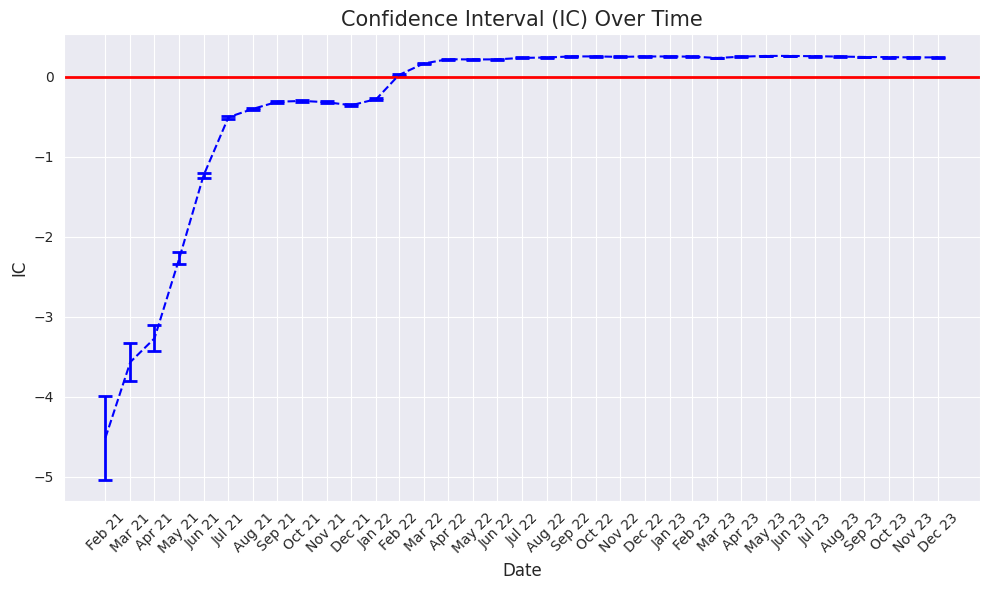

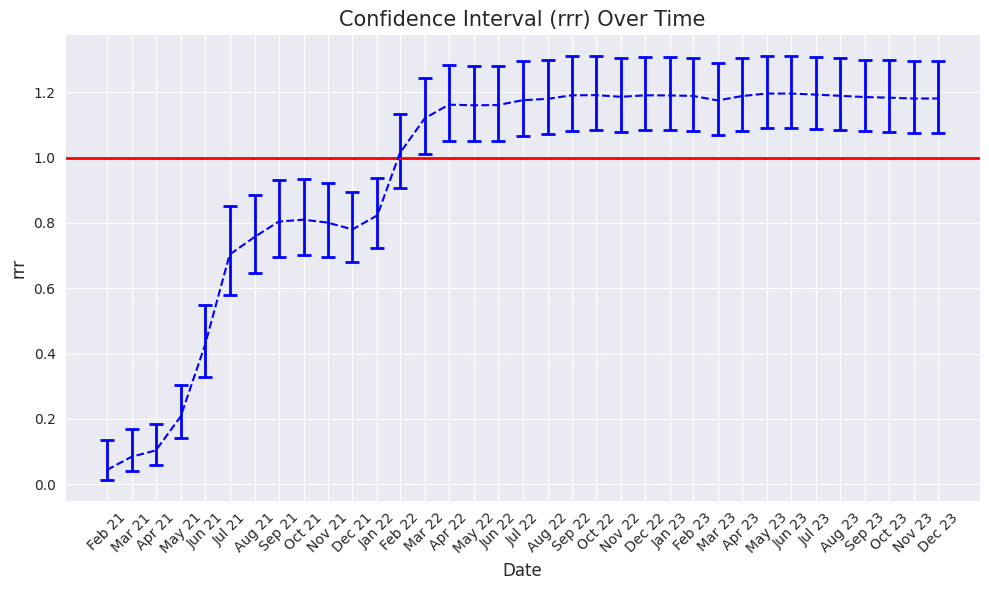

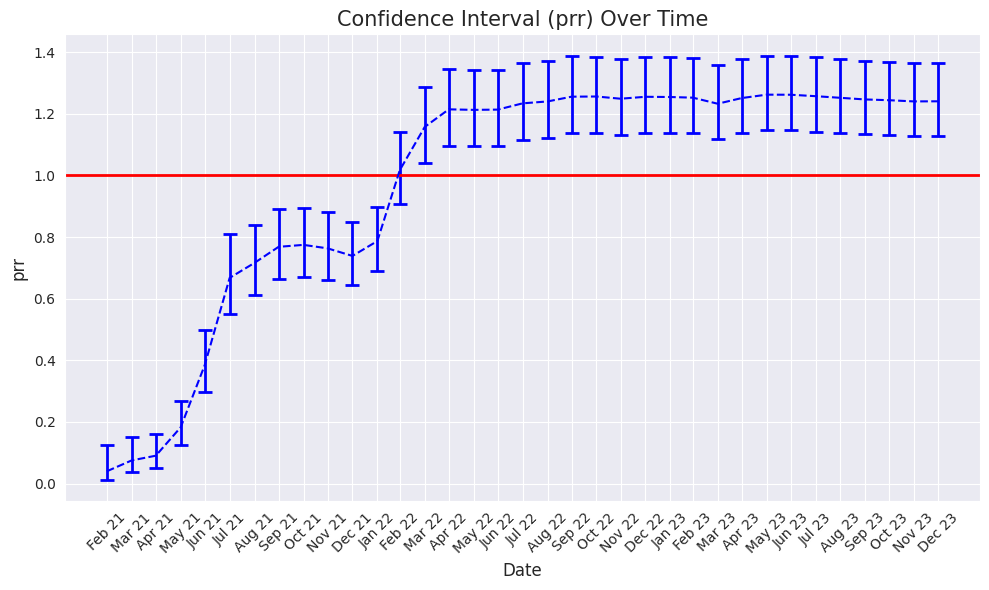

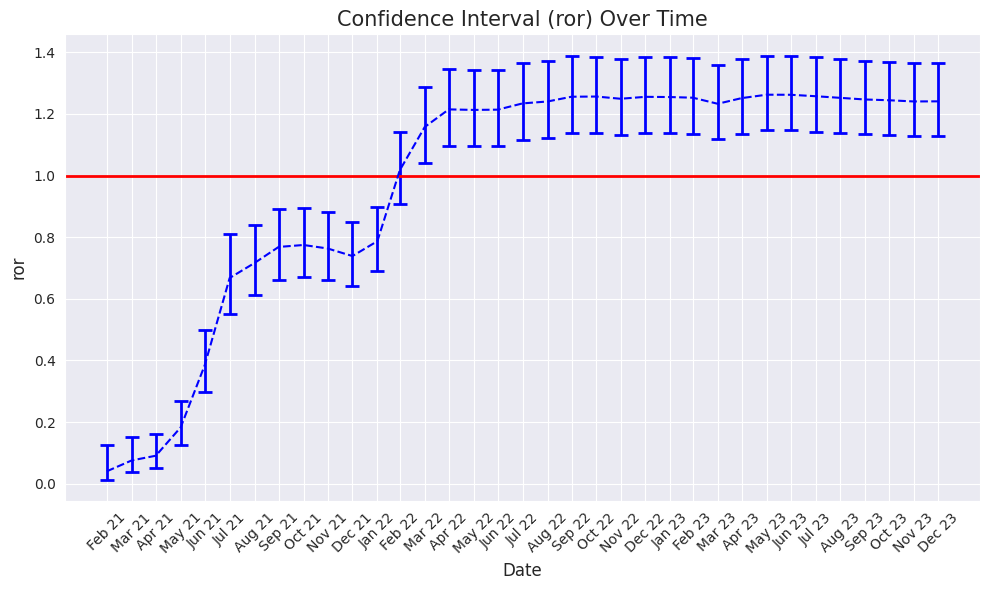

In [181]:
import pandas as pd
import matplotlib.pyplot as plt

manufacturer = df['manufacturer'][0]
symptom = df['symptom'][0]
methods = ["IC", "rrr", "prr", "ror"]
# Convert the 'Date' column to datetime, coercing errors to NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with NaT dates
df = df.dropna(subset=['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Create a list of formatted date strings
formatted_dates = df['Date'].dt.strftime('%b %y')

for method in methods:
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df[f'{method}'], yerr=[df[f'{method}'] - df[f'{method} Lower'], df[f'{method} Upper'] - df[f'{method}']], fmt='--', color='blue', ecolor='blue', capsize=5, capthick=2, elinewidth=2)
    
    # Add a red horizontal line at y=
    if method == 'IC':
        plt.axhline(y=0, color='red', linestyle='-', linewidth=2)
    elif method == 'rrr' or "prr" or "ror":
        plt.axhline(y=1, color='red', linestyle='-', linewidth=2)
    
    # Set custom x-axis ticks
    plt.xticks(df['Date'], formatted_dates, rotation=45)
    
    # Set labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{method}', fontsize=12)
    plt.title(f'Confidence Interval ({method}) Over Time', fontsize=15)
    
    # Show the plot
    plt.tight_layout()
    directory = f'/home/sebastian/Documents/Masterarbeit/Plots/CI_intervals/{symptom}_{manufacturer}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(f'/home/sebastian/Documents/Masterarbeit/Plots/CI_intervals/{symptom}_{manufacturer}/{method}.eps', format='eps')


### check yearly

In [182]:
# Loop until a signal is not found anymore

manufacturer = "MERCK & CO. INC."#"PFIZER\\BIONTECH"
symptom = "Nausea"
vaccine = "MMR"
IC_intervals = []

 
start_date = datetime(2023, 12, 31)
end_date = datetime(1990, 12, 31)
first_found = datetime(1990, 1, 1)
while True:
    print(f'checking {start_date}')
    N_query = {"RECVDATE": {"$lte": start_date}}
    N = col.count_documents(N_query)
    
    D_query = {
        "RECVDATE": {"$lte": start_date},
        "vax_data": {
            "$elemMatch": {
                "VAX_MANU": manufacturer,
                "VAX_TYPE": vaccine
            }
        }
    }
    D = col.count_documents(D_query)
    
    E_query = {
        "RECVDATE": {"$lte": start_date},
        "symptoms": {
            "$elemMatch": {
                "$in": [symptom]
            }
        }
    }
    E = col.count_documents(E_query)
    
    DE_query = {'$and': [D_query, E_query]}
    DE = col.count_documents(DE_query)
    if DE >= 3: 
    
        De = D - DE
        dE = E - DE
        de = N - (DE + De + dE)
        
            
        # Ensure all necessary data is available
        if None in [DE, dE, De, de]:
            continue
        
        contingency_table = [
            [DE, dE],
            [De, de]
        ]

        rrr, sd_rrr = disproportionaly_analysis.relative_reporting_ratio(contingency_table), disproportionaly_analysis.sd_rrr(contingency_table)
        rrr_ci_lower, rrr_ci_upper = disproportionaly_analysis.confidence_interval(rrr, sd_rrr)
        
        prr, sd_prr = disproportionaly_analysis.proportional_reporting_ratio(contingency_table), disproportionaly_analysis.sd_prr(contingency_table)
        prr_ci_lower, prr_ci_upper = disproportionaly_analysis.confidence_interval(prr, sd_prr)
        
        ror, sd_ror = disproportionaly_analysis.reporting_odds_ratio(contingency_table), disproportionaly_analysis.sd_ror(contingency_table)
        ror_ci_lower, ror_ci_upper = disproportionaly_analysis.confidence_interval(ror, sd_ror)
        
        chi_square = disproportionaly_analysis.chi_square_yates(contingency_table)
        IC = disproportionaly_analysis.information_component(contingency_table)
        IC_ci_lower, IC_ci_upper = disproportionaly_analysis.confidence_interval_information_component(contingency_table, IC)
        
        IC_intervals.append({
            'Date': start_date,
            'manufacturer': manufacturer,
            'symptom': symptom,
            'IC': IC,
            'IC Lower': IC_ci_lower,
            'IC Upper': IC_ci_upper,
            'rrr': rrr, 
            'rrr Lower': rrr_ci_lower,
            'rrr Upper': rrr_ci_upper,
            'prr': prr, 
            'prr Lower': prr_ci_lower,
            'prr Upper': prr_ci_upper,
            'ror': ror, 
            'ror Lower': ror_ci_lower,
            'ror Upper': ror_ci_upper,
        })
        
        start_date = reduce_date_range_by_year(start_date)
        #print(f"Reducing by a month..., checking {start_date}")# Exit the loop if no signal is found anymore
        if start_date < end_date:
            break
    else:
        print(f"DE is {DE}")
        break

checking 2023-12-31 00:00:00
checking 2022-12-31 00:00:00
checking 2021-12-31 00:00:00
checking 2020-12-31 00:00:00
checking 2019-12-31 00:00:00
checking 2018-12-31 00:00:00
checking 2017-12-31 00:00:00
checking 2016-12-31 00:00:00
checking 2015-12-31 00:00:00
checking 2014-12-31 00:00:00
checking 2013-12-31 00:00:00
checking 2012-12-31 00:00:00
checking 2011-12-31 00:00:00
checking 2010-12-31 00:00:00
checking 2009-12-31 00:00:00
checking 2008-12-31 00:00:00
checking 2007-12-31 00:00:00
checking 2006-12-31 00:00:00
checking 2005-12-31 00:00:00
checking 2004-12-31 00:00:00
checking 2003-12-31 00:00:00
checking 2002-12-31 00:00:00
checking 2001-12-31 00:00:00
checking 2000-12-31 00:00:00
checking 1999-12-31 00:00:00
checking 1998-12-31 00:00:00
checking 1997-12-31 00:00:00
checking 1996-12-31 00:00:00
checking 1995-12-31 00:00:00
checking 1994-12-31 00:00:00
checking 1993-12-31 00:00:00
checking 1992-12-31 00:00:00
checking 1991-12-31 00:00:00
checking 1990-12-31 00:00:00


In [183]:
df = pd.DataFrame(IC_intervals)

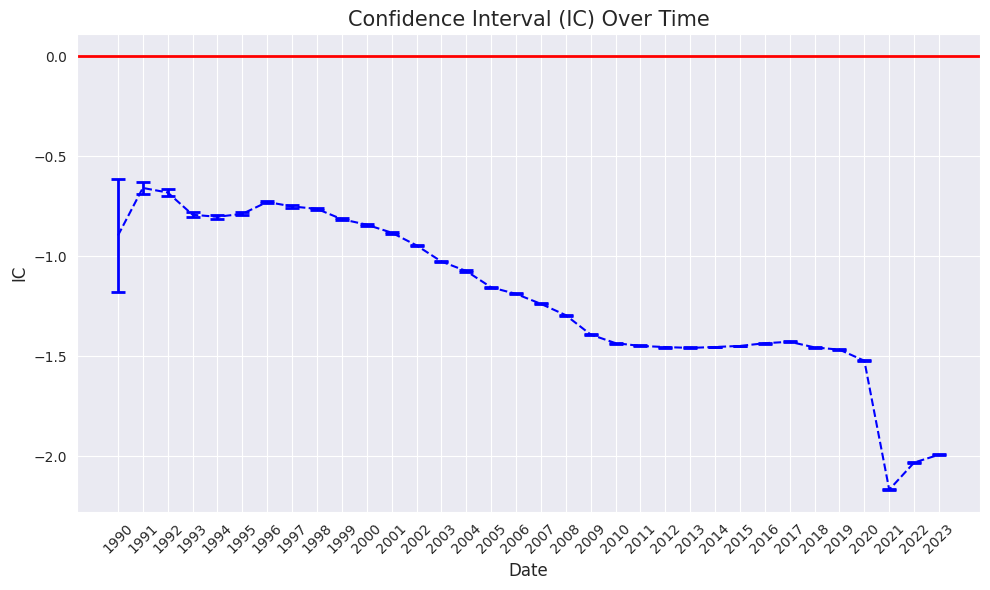

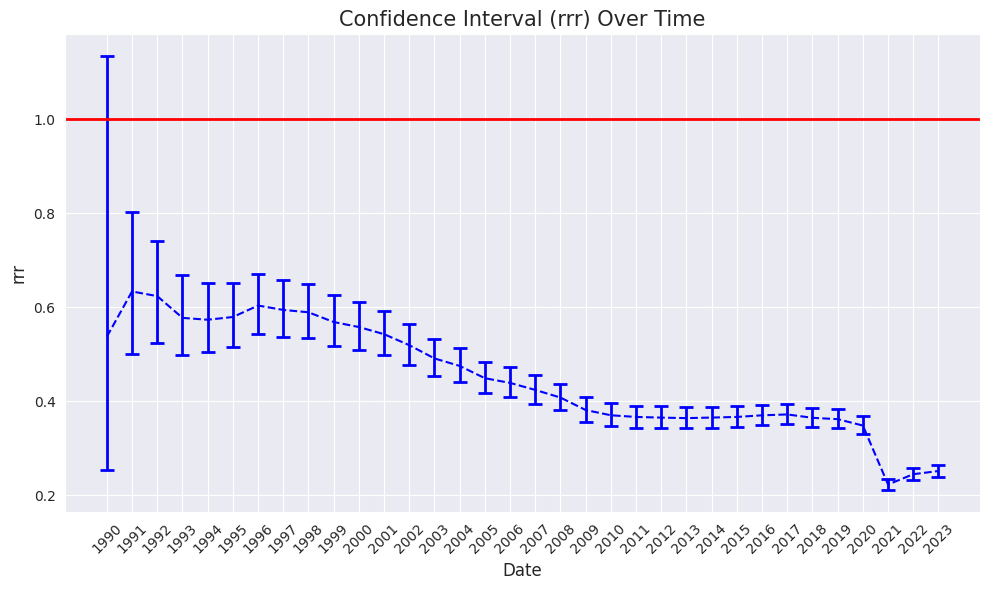

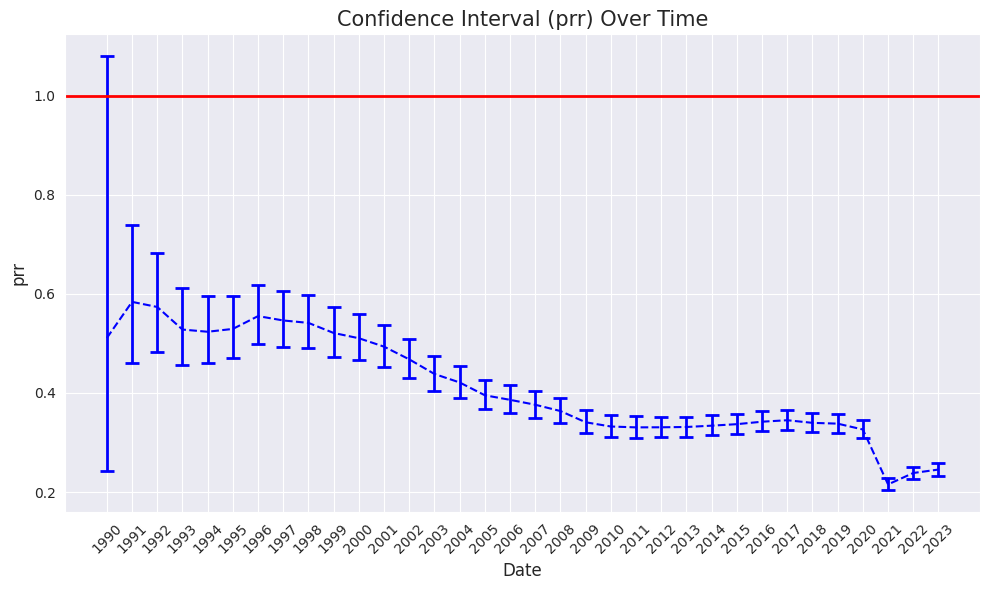

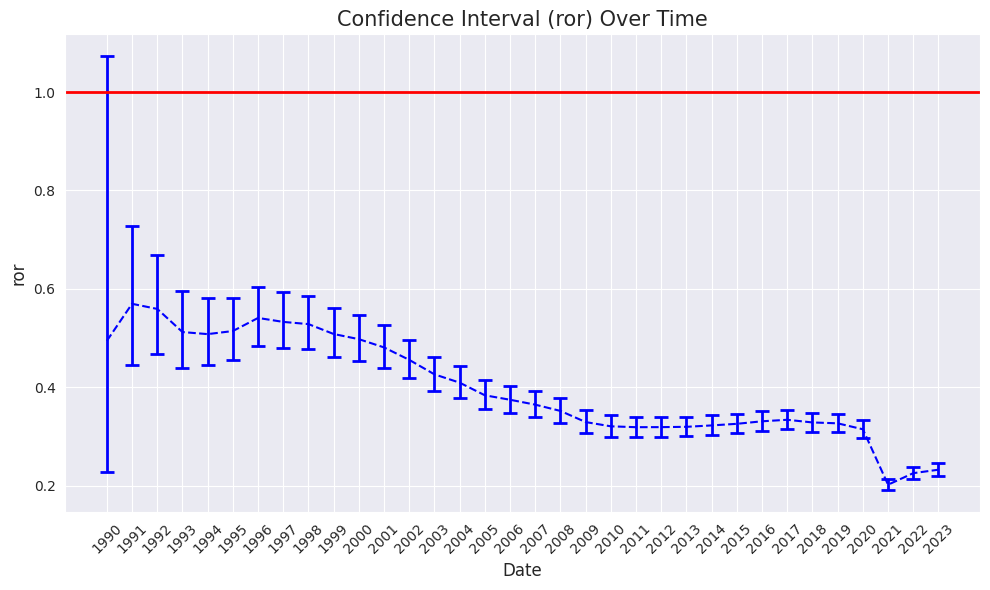

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
manufacturer = df['manufacturer'][0]
symptom = df['symptom'][0]
methods = ["IC", "rrr", "prr", "ror"]
# Convert the 'Date' column to datetime, coercing errors to NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with NaT dates
df = df.dropna(subset=['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

import pandas as pd
import matplotlib.pyplot as plt
manufacturer = df['manufacturer'][0]
symptom = df['symptom'][0]
methods = ["IC", "rrr", "prr", "ror"]
# Convert the 'Date' column to datetime, coercing errors to NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with NaT dates
df = df.dropna(subset=['Date'])

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Create a list of formatted date strings
formatted_dates = df['Date'].dt.strftime('%Y')

for method in methods:
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df[f'{method}'], yerr=[df[f'{method}'] - df[f'{method} Lower'], df[f'{method} Upper'] - df[f'{method}']], fmt='--', color='blue', ecolor='blue', capsize=5, capthick=2, elinewidth=2)
    
    # Add a red horizontal line at y=
    if method == 'IC':
        plt.axhline(y=0, color='red', linestyle='-', linewidth=2)
    elif method == 'rrr' or "prr" or "ror":
        plt.axhline(y=1, color='red', linestyle='-', linewidth=2)
    
    # Set custom x-axis ticks
    plt.xticks(df['Date'], formatted_dates, rotation=45)
    
    # Set labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{method}', fontsize=12)
    plt.title(f'Confidence Interval ({method}) Over Time', fontsize=15)
    
    # Show the plot
    plt.tight_layout()
    directory = f'/home/sebastian/Documents/Masterarbeit/Plots/CI_intervals/{symptom}_{manufacturer}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(f'/home/sebastian/Documents/Masterarbeit/Plots/CI_intervals/{symptom}_{manufacturer}/{method}.png')#, format='eps')


In [170]:
df

,Date,manufacturer,symptom,IC,IC Lower,IC Upper,rrr,rrr Lower,rrr Upper,prr,prr Lower,prr Upper,ror,ror Lower,ror Upper
33,1990-12-31,MERCK & CO. INC.,Nausea,-0.896743,-1.179331,-0.614155,0.537098,0.254405,1.133918,0.510966,0.241791,1.079801,0.494429,0.227810,1.073088
32,1991-12-31,MERCK & CO. INC.,Nausea,-0.659025,-0.690101,-0.627949,0.633306,0.500585,0.801215,0.583842,0.460756,0.739808,0.569680,0.445654,0.728224
31,1992-12-31,MERCK & CO. INC.,Nausea,-0.681890,-0.698716,-0.665063,0.623348,0.524504,0.740820,0.573487,0.482007,0.682328,0.559259,0.467086,0.669623
30,1993-12-31,MERCK & CO. INC.,Nausea,-0.793051,-0.805061,-0.781041,0.577122,0.498885,0.667630,0.527956,0.456047,0.611204,0.512279,0.440148,0.596229
29,1994-12-31,MERCK & CO. INC.,Nausea,-0.803005,-0.812320,-0.793691,0.573154,0.504138,0.651618,0.523535,0.460194,0.595593,0.508081,0.444561,0.580676
28,1995-12-31,MERCK & CO. INC.,Nausea,-0.788442,-0.796135,-0.780750,0.578969,0.515233,0.650589,0.529242,0.470693,0.595074,0.514326,0.455564,0.580666
27,1996-12-31,MERCK & CO. INC.,Nausea,-0.729083,-0.735557,-0.722609,0.603287,0.542094,0.671388,0.555104,0.498502,0.618132,0.540960,0.483992,0.604633
26,1997-12-31,MERCK & CO. INC.,Nausea,-0.751362,-0.757318,-0.745405,0.594043,0.536045,0.658315,0.546297,0.492696,0.605731,0.532888,0.479004,0.592834
25,1998-12-31,MERCK & CO. INC.,Nausea,-0.763659,-0.769129,-0.758189,0.589000,0.533736,0.649987,0.541413,0.490367,0.597774,0.528439,0.477155,0.585237
24,1999-12-31,MERCK & CO. INC.,Nausea,-0.815119,-0.820237,-0.810002,0.568362,0.516648,0.625252,0.521066,0.473447,0.573474,0.508349,0.460608,0.561038
